##### $\hspace{15pt}$ **Filename: shap.ipynb**
##### $\hspace{1.5pt}$ **Date Created: December 20, 2023**
##### **Date Modified: January 13, 2024**
##### $\rule{10.5in}{1pt}$
##### **Display different types of [SHAP](https://shap.readthedocs.io/en/latest/index.html#) plots after training an XGBoost regression model on the [Boston house prices dataset](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data) from Kaggle.**

##### **The file `boston.csv` that has to be accessed is available in this [Google Drive folder](https://drive.google.com/drive/folders/1cy-vNYIYgwZrDqG0N9lyqdyNciRmQzto?usp=sharing). Before running this notebook in Colab, either change the path in cell `4`, or create the subfolder `/Colab Notebooks/009_shap` in your Google drive and copy the file to the subfolder. Restart the runtime after installing the packages and before running the remaining cells of the notebook.**

##### $\rule{10.5in}{1pt}$

##### Install `dython` and `shap`.

In [ ]:
!pip install dython -q shap -q

##### Update `seaborn`.

In [ ]:
!pip install -U seaborn -q

##### Restart the runtime, and load modules and packages.

In [ ]:
from dython.nominal import associations
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import sklearn
import xgboost as xgb

##### Set the float format of pandas dataframes.

In [ ]:
pd.options.display.float_format = "{:.4f}".format

##### Mount Google Drive to Colab.

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##### Set the path to access the file needed by this notebook.

In [ ]:
path = "gdrive/MyDrive/Colab Notebooks/009_shap/"

##### Load the dataset from Google Drive.

In [ ]:
dataset = pd.read_csv(path + "boston.csv")
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.0063,18.0000,2.3100,0,0.5380,6.5750,65.2000,4.0900,1,296.0000,15.3000,396.9000,4.9800,24.0000
1,0.0273,0.0000,7.0700,0,0.4690,6.4210,78.9000,4.9671,2,242.0000,17.8000,396.9000,9.1400,21.6000
2,0.0273,0.0000,7.0700,0,0.4690,7.1850,61.1000,4.9671,2,242.0000,17.8000,392.8300,4.0300,34.7000
3,0.0324,0.0000,2.1800,0,0.4580,6.9980,45.8000,6.0622,3,222.0000,18.7000,394.6300,2.9400,33.4000
4,0.0691,0.0000,2.1800,0,0.4580,7.1470,54.2000,6.0622,3,222.0000,18.7000,396.9000,5.3300,36.2000


##### Check if there are missing values.

In [ ]:
dataset.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

##### Visualize the continuous features in the dataset.

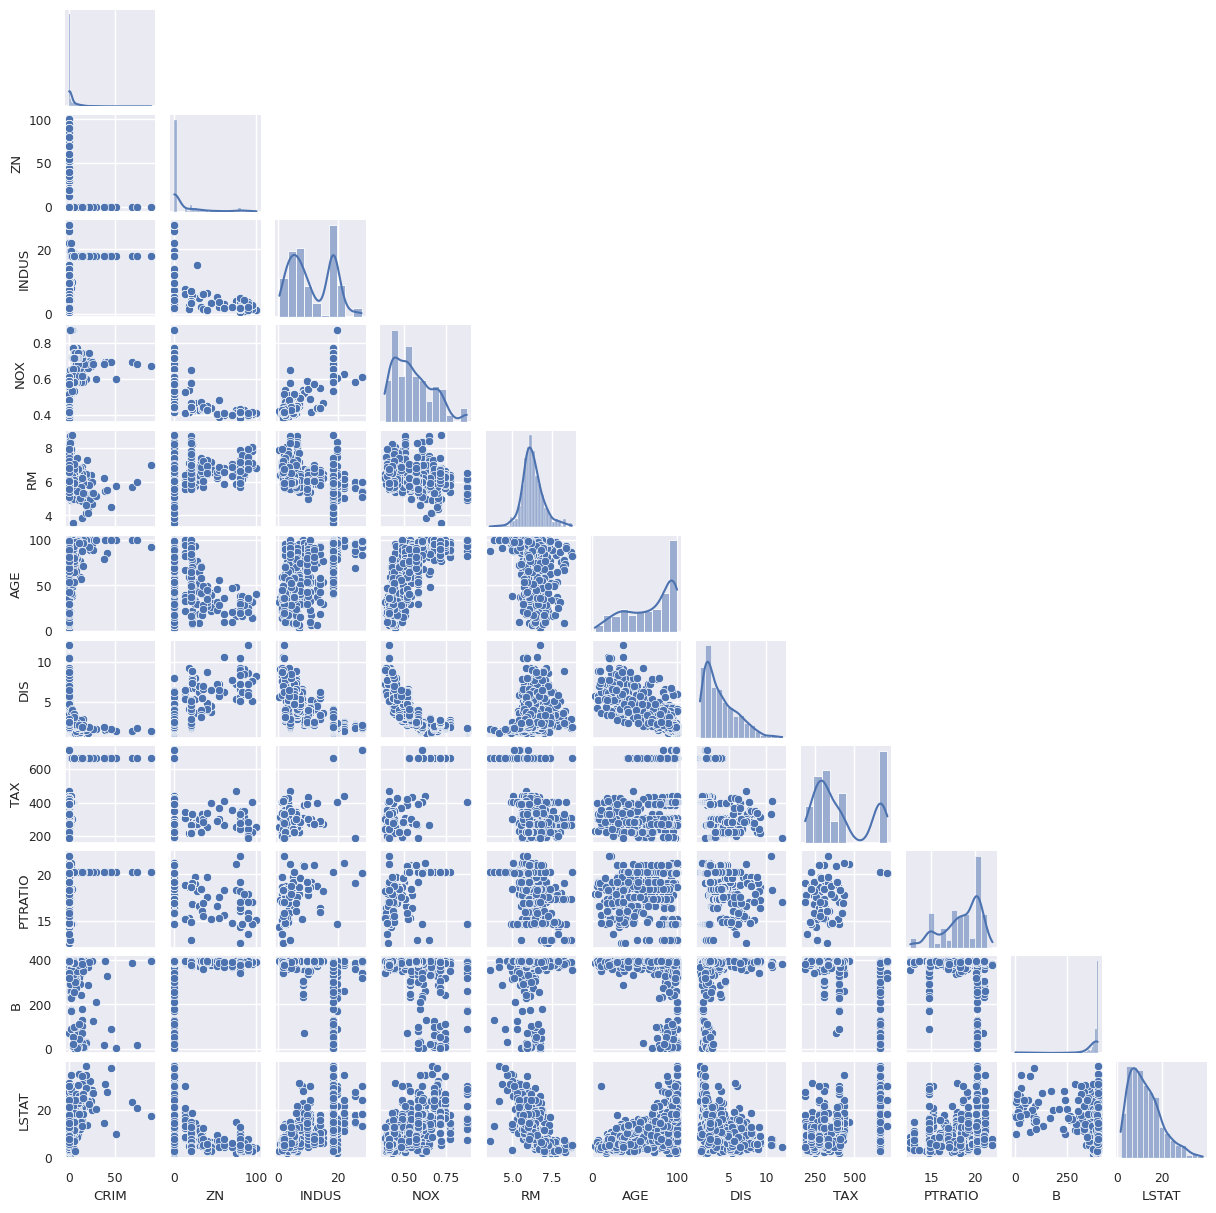

In [ ]:
sns.set_style("white")
sns.set(font_scale = 0.8)
grid = sns.PairGrid(dataset, vars = ["CRIM", "ZN", "INDUS", "NOX", "RM", "AGE", "DIS", "TAX", "PTRATIO", "B", "LSTAT"], corner = True,
                    diag_sharey = False)
grid.fig.set_size_inches(12, 12)
grid.map_diag(sns.histplot, stat = "percent", kde = True)
grid.map_lower(sns.scatterplot)
plt.show()

##### Visualize the categorical features in the dataset.

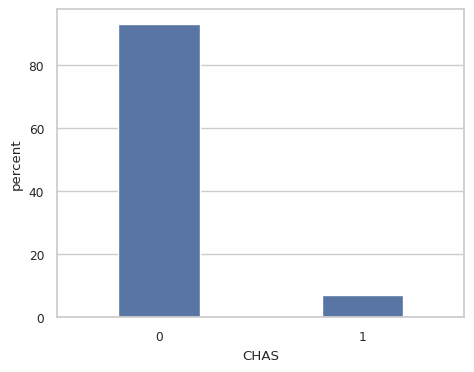

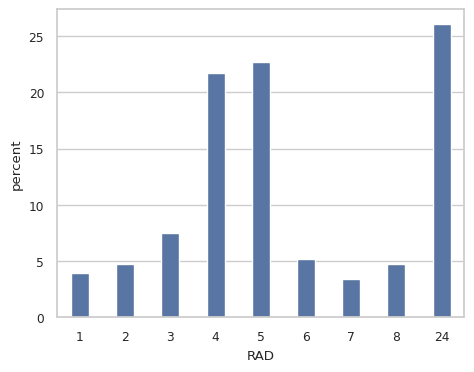

In [ ]:
plt.rcParams["figure.figsize"] = [5.25, 4]
sns.set_style("whitegrid")

categoricalFeatures = ["CHAS", "RAD"]

for feature in categoricalFeatures:

    uniqueValues = dataset[feature].unique().tolist()
    uniqueValues.sort()
    sns.countplot(data = dataset, x = feature, order = uniqueValues, stat = "percent", width = 0.4)
    plt.show()

##### Visualize the target in the dataset.

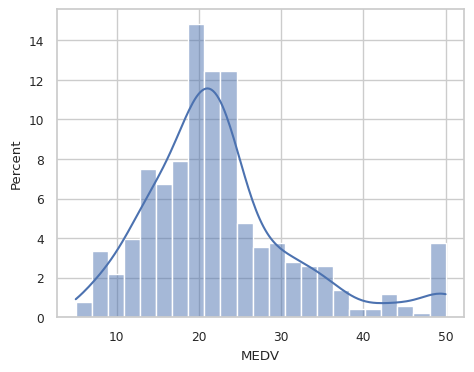

In [ ]:
sns.histplot(data = dataset, x = "MEDV", stat = "percent", kde = True)
plt.show()

##### Extract the input data from the dataset.

In [ ]:
inputData = dataset.drop(columns = ["MEDV"])
inputData.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.0063,18.0000,2.3100,0,0.5380,6.5750,65.2000,4.0900,1,296.0000,15.3000,396.9000,4.9800
1,0.0273,0.0000,7.0700,0,0.4690,6.4210,78.9000,4.9671,2,242.0000,17.8000,396.9000,9.1400
2,0.0273,0.0000,7.0700,0,0.4690,7.1850,61.1000,4.9671,2,242.0000,17.8000,392.8300,4.0300
3,0.0324,0.0000,2.1800,0,0.4580,6.9980,45.8000,6.0622,3,222.0000,18.7000,394.6300,2.9400
4,0.0691,0.0000,2.1800,0,0.4580,7.1470,54.2000,6.0622,3,222.0000,18.7000,396.9000,5.3300


##### Extract the target data from the dataset.

In [ ]:
targetData = dataset[["MEDV"]]
targetData.head()

,MEDV
0,24.0000
1,21.6000
2,34.7000
3,33.4000
4,36.2000


##### Split the dataset into train and test sets.

In [ ]:
xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(inputData, targetData, test_size = 0.3, random_state = 1)

In [ ]:
xTrain.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
13,0.6298,0.0000,8.1400,0,0.5380,5.9490,61.8000,4.7075,4,307.0000,21.0000,396.9000,8.2600
61,0.1717,25.0000,5.1300,0,0.4530,5.9660,93.4000,6.8185,8,284.0000,19.7000,378.0800,14.4400
377,9.8235,0.0000,18.1000,0,0.6710,6.7940,98.8000,1.3580,24,666.0000,20.2000,396.9000,21.2400
39,0.0276,75.0000,2.9500,0,0.4280,6.5950,21.8000,5.4011,3,252.0000,18.3000,395.6300,4.3200
365,4.5559,0.0000,18.1000,0,0.7180,3.5610,87.9000,1.6132,24,666.0000,20.2000,354.7000,7.1200


In [ ]:
yTrain.head()

,MEDV
13,20.4000
61,16.0000
377,13.3000
39,30.8000
365,27.5000


In [ ]:
len(xTrain)

354

In [ ]:
xTest.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
307,0.0493,33.0000,2.1800,0,0.4720,6.8490,70.3000,3.1827,7,222.0000,18.4000,396.9000,7.5300
343,0.0254,55.0000,3.7800,0,0.4840,6.6960,56.4000,5.7321,5,370.0000,17.6000,396.9000,7.1800
47,0.2293,0.0000,6.9100,0,0.4480,6.0300,85.5000,5.6894,3,233.0000,17.9000,392.7400,18.8000
67,0.0579,12.5000,6.0700,0,0.4090,5.8780,21.4000,6.4980,4,345.0000,18.9000,396.2100,8.1000
362,3.6782,0.0000,18.1000,0,0.7700,5.3620,96.2000,2.1036,24,666.0000,20.2000,380.7900,10.1900


In [ ]:
yTest.head()

,MEDV
307,28.2000
343,23.9000
47,16.6000
67,22.0000
362,20.8000


In [ ]:
len(xTest)

152

##### Visualize the target in the train set.

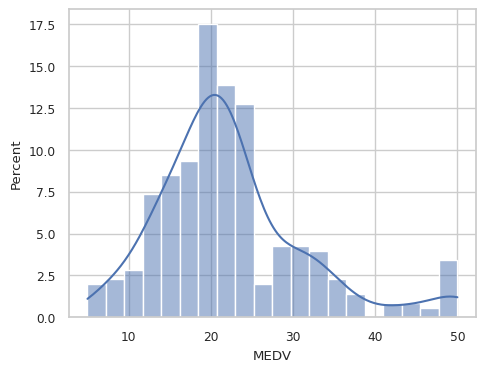

In [ ]:
trainSet = pd.concat([xTrain, yTrain], axis = 1)

sns.histplot(data = trainSet, x = "MEDV", stat = "percent", kde = True)
plt.show()

##### Create a correlation heatmap using the variables in the train set.

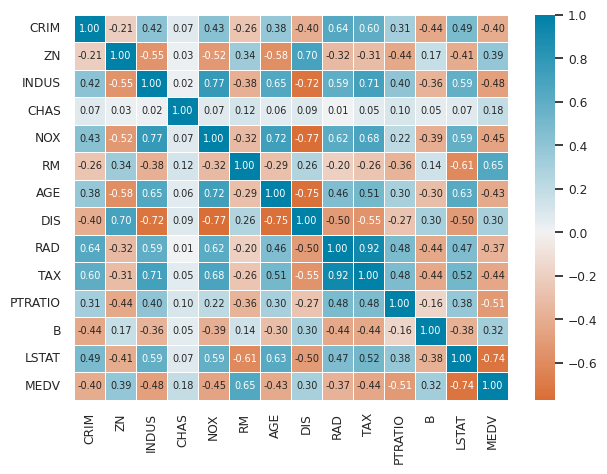

In [ ]:
plt.figure(figsize = (7, 5))
sns.set(font_scale = 0.8)
correlationMatrix = associations(trainSet, nominal_columns = ["CHAS"], compute_only = True)["corr"]
cmap = sns.diverging_palette(20, 230, s = 100, as_cmap = True)
sns.heatmap(correlationMatrix, cmap = cmap, center = 0, annot = True, annot_kws = {"fontsize": 7}, fmt = ".2f", linewidths = 0.5)
plt.show()

##### Train an XGBoost regression model.

In [ ]:
xgbRegressor = xgb.XGBRegressor()
xgbRegressor.fit(xTrain, yTrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##### Create a SHAP explainer object, and calculate the SHAP values for every obervation in the test set.

In [ ]:
explainer = shap.Explainer(xgbRegressor)
shapValues = explainer(xTest)

[17:58:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


$\hspace{1in}$

##### **Waterfall Plot**

##### Create a watefall plot to visualize the SHAP values of an observation in the test set. For example, a waterfall plot for the first observation in the test set is displayed below.

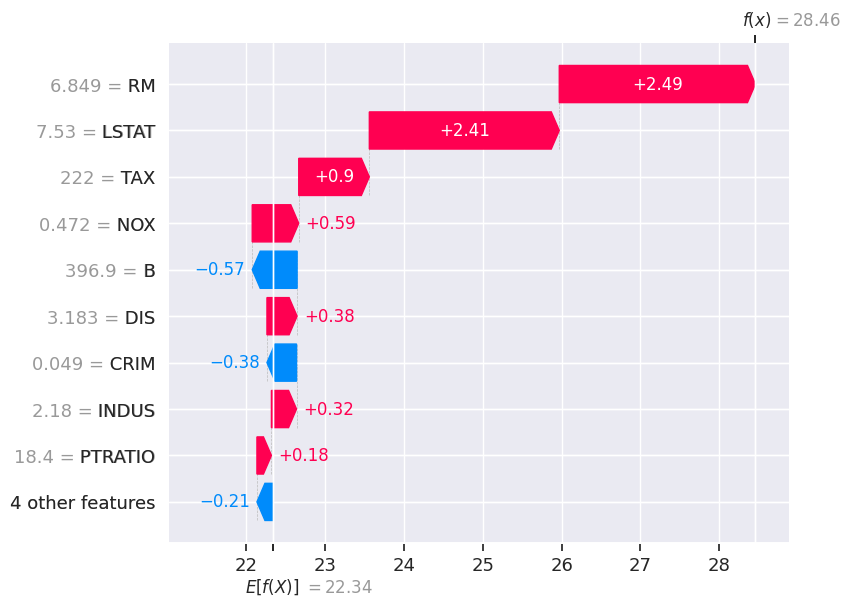

In [ ]:
shap.plots.waterfall(shapValues[0])

$\hspace{1in}$

##### **Force Plot**

##### Create a force plot to visualize the SHAP values of an observation in the test set. For example, a force plot for the first observation in the test set is displayed below.

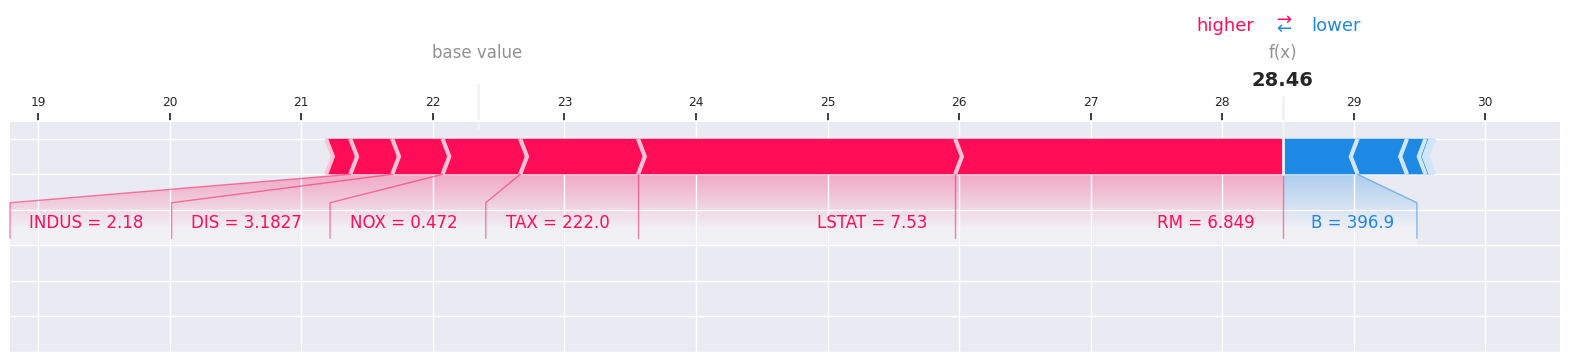

In [ ]:
shap.plots.force(shapValues[0], matplotlib = True)

$\hspace{1in}$

##### **Stacked Force Plot**

##### Create a stacked force plot to visualize the SHAP values of all the observations in the test set.

In [ ]:
shap.initjs()
shap.plots.force(shapValues)

$\hspace{1in}$

##### **Decision Plot**

##### Create a decision plot to visualize how predictions are arrived at using cumulative SHAP values. For example, a decision plot for the first observation in the test set is displayed below.

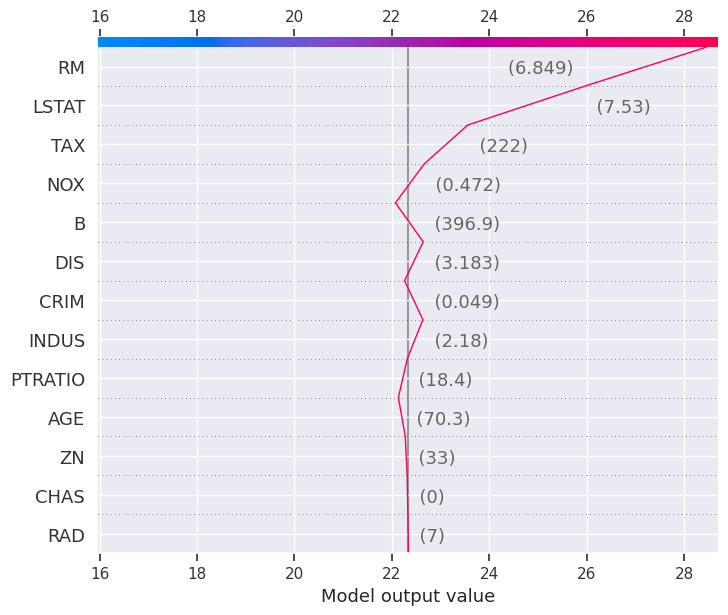

In [ ]:
shap.decision_plot(explainer.expected_value, shapValues.values[0], xTest.iloc[0])

$\hspace{1in}$

##### **Bar Plot**

##### Create a bar plot to visualize the mean of the absolute value of the SHAP values of each feature over all observations in the test set.

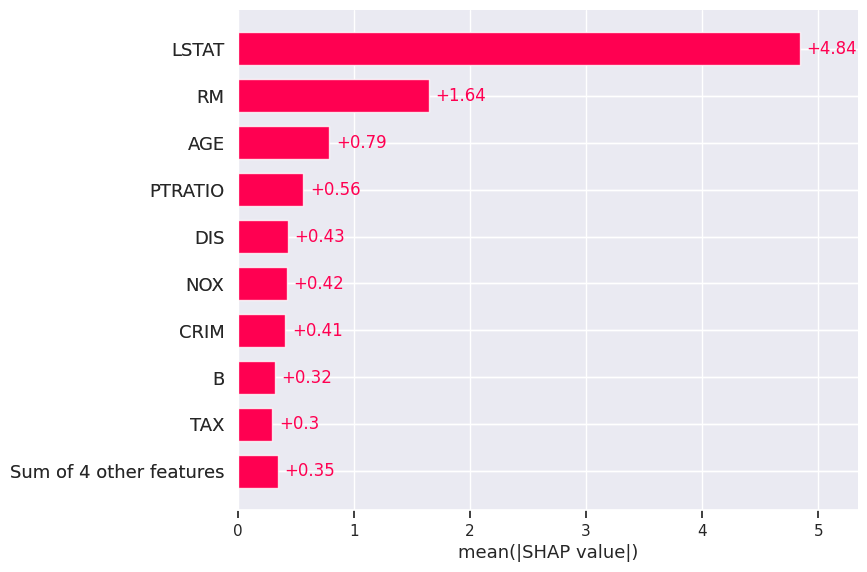

In [ ]:
shap.plots.bar(shapValues)

$\hspace{1in}$

##### **Beeswarm Plot**

##### Create a beeswarm plot to visualize the SHAP values of all the observations in the test set.

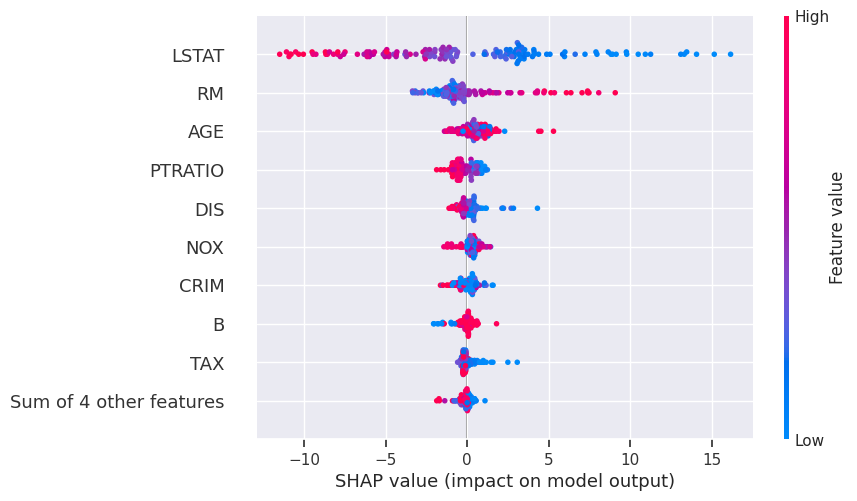

In [ ]:
shap.plots.beeswarm(shapValues)

$\hspace{1in}$

##### **Violin Plot**

##### Create a violin plot to visualize the SHAP values of all the observations in the test set.

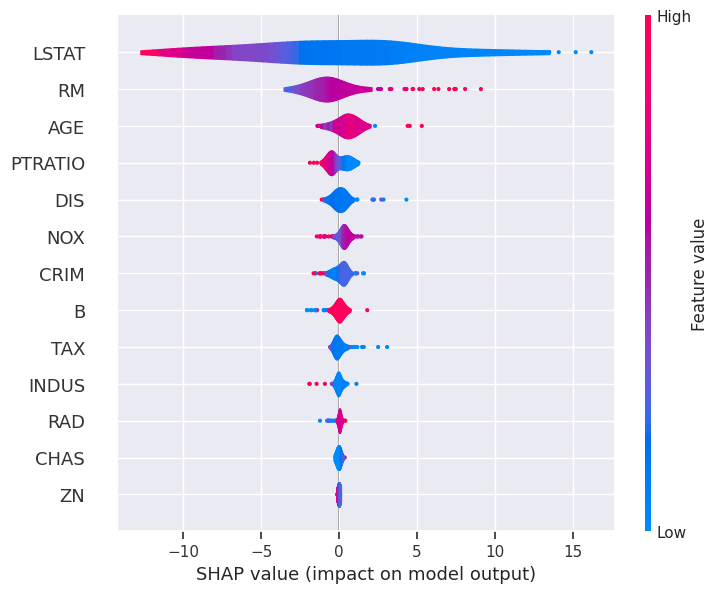

In [ ]:
shap.plots.violin(shapValues)

$\hspace{1in}$

##### **Heatmap Plot**

##### Create a heatmap plot to visualize the SHAP values of all the observations in the test set.

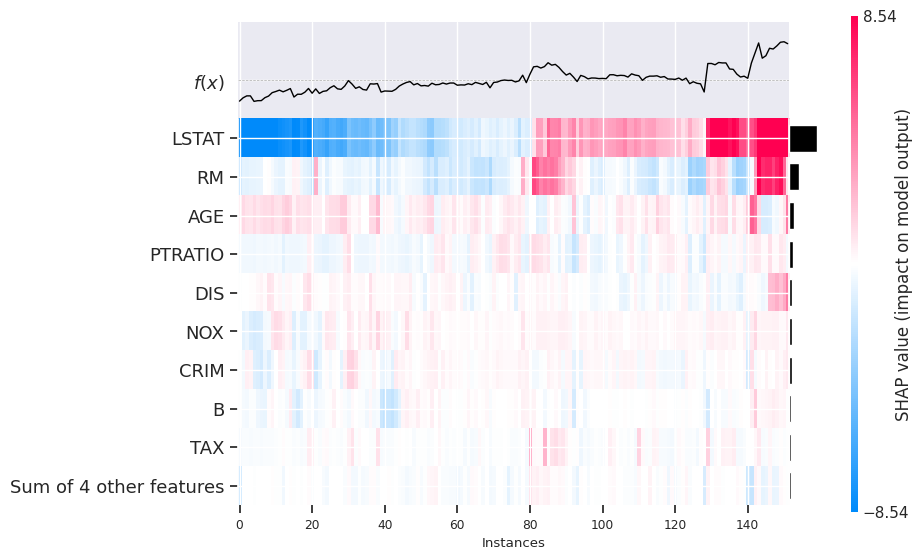

In [ ]:
shap.plots.heatmap(shapValues)

$\hspace{1in}$

##### **Dependence Plot**

##### Create a dependence plot to visualize the SHAP values of a feature against the feature values. For example, a dependence plot for `LSTAT` is displayed below.

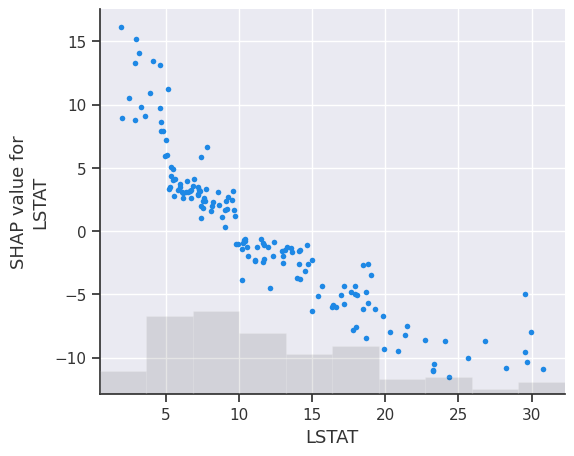

In [ ]:
shap.plots.scatter(shapValues[:, "LSTAT"])